In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

def eval (out, model, label):
    probs = model.activate(out)
    unc = model.aleatoric(out).cpu()
    pmax = probs.argmax(dim=1)
    lmax = label.argmax(dim=1)
    mis = pmax.cpu() != lmax.cpu()

    agree = mis.bool() == (unc > .5)

    return agree.float().mean().item()


In [164]:
torch.manual_seed(0)

In [18]:
from models.evidential import *

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [46]:
from datasets.carla import compile_data as compile_data_carla
from datasets.nuscenes import compile_data as compile_data_nuscenes
from tools.utils import *

In [213]:
ufce_reg_vac = Evidential([7], backbone="cvt", n_classes=2)
ufce_reg_vac.load(torch.load("../outputs_bin/nuscenes/aug/cvt_ufocal_gamma=.05_ol=.01_k=64/17.pt"))
ufce_reg = Evidential([7], backbone="cvt", n_classes=2)
ufce_reg.load(torch.load("../outputs_bin/nuscenes/aug/cvt_ufocal_gamma=.05_ol=.01_k=0/15.pt"))
uce_reg = Evidential([7], backbone="cvt", n_classes=2)
uce_reg.load(torch.load("../outputs_bin/nuscenes/aug/cvt_uce_ol=.01_k=0/10.pt"))
ufce = Evidential([7], backbone="cvt", n_classes=2)
ufce.load(torch.load("../outputs_bin/nuscenes/vehicle/cvt_ufocal_gamma=.05/19.pt"))

Loaded pretrained weights for efficientnet-b4
BETA LAMBDA: 0.001
Loaded pretrained weights for efficientnet-b4
BETA LAMBDA: 0.001
Loaded pretrained weights for efficientnet-b4
BETA LAMBDA: 0.001
Loaded pretrained weights for efficientnet-b4
BETA LAMBDA: 0.001


In [ ]:
loader_c = compile_data_carla("ood", "mini", "../../data/carla", "vehicle")
loader_n = compile_data_nuscenes("ood", "mini", "../../data/nuscenes", "vehicle")

In [181]:
def get_ep(idx, model):
    images, intrinsics, extrinsics, labels, oods = loader_n.dataset[idx]
    images = images[None].to(7)
    intrinsics = intrinsics[None].to(7)
    extrinsics = extrinsics[None].to(7)
    
    alpha = model(images, intrinsics, extrinsics)
    preds = model.activate(alpha)
    ep = model.epistemic(alpha)

    return ep, oods

In [186]:
max = 0
midx = 0

for i in range(1000):
    images, intrinsics, extrinsics, labels, oods = loader_n.dataset[i]

    if oods.sum() > max:
        max = oods.sum()
        midx = i
        print(max, midx)

tensor(27., dtype=torch.float64) 0
tensor(28., dtype=torch.float64) 13
tensor(29., dtype=torch.float64) 20
tensor(31., dtype=torch.float64) 47
tensor(34., dtype=torch.float64) 63
tensor(57., dtype=torch.float64) 73
tensor(67., dtype=torch.float64) 76
tensor(88., dtype=torch.float64) 169
tensor(95., dtype=torch.float64) 170
tensor(101., dtype=torch.float64) 173
tensor(112., dtype=torch.float64) 174
tensor(124., dtype=torch.float64) 731
tensor(179., dtype=torch.float64) 799
tensor(182., dtype=torch.float64) 804
tensor(184., dtype=torch.float64) 806
tensor(187., dtype=torch.float64) 810


In [ ]:
print(max, midx)

tensor(718287.8750, device='cuda:7')
tensor(297.9759, device='cuda:7', grad_fn=<SumBackward0>)
tensor(718287.8750, device='cuda:7')
tensor(299.7743, device='cuda:7', grad_fn=<SumBackward0>)
tensor(718287.8750, device='cuda:7')
tensor(484.7327, device='cuda:7', grad_fn=<SumBackward0>)
tensor(718287.8750, device='cuda:7')
tensor(1087.1589, device='cuda:7', grad_fn=<SumBackward0>)
tensor(718287.8750, device='cuda:7')
tensor(144.8786, device='cuda:7', grad_fn=<SumBackward0>)


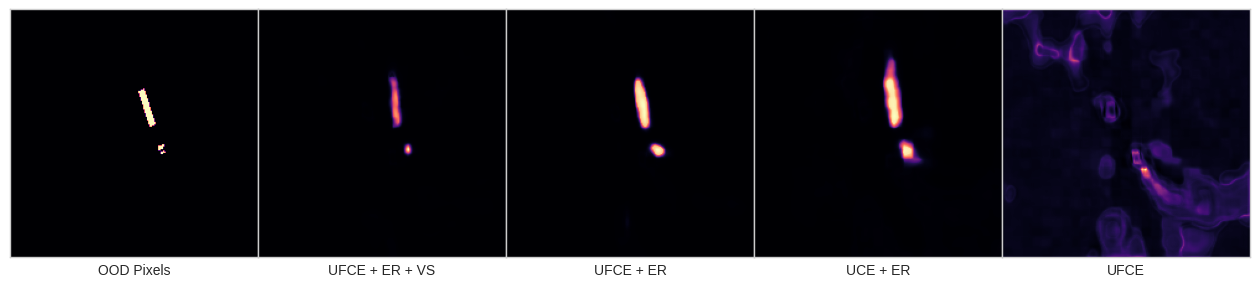

In [223]:
fig, axs = plt.subplots(1, 5, figsize=(16, 32))
fig.subplots_adjust(wspace=0, hspace=0)

idx = 810
ep, oods = get_ep(idx, ufce_reg_vac)
axs[0].imshow(oods[0], cmap="magma")
axs[1].imshow(get_ep(idx, ufce_reg_vac)[0][0, 0].detach().cpu(), cmap="magma")
axs[2].imshow(get_ep(idx, ufce_reg)[0][0, 0].detach().cpu(), cmap="magma")
axs[3].imshow(get_ep(idx, uce_reg)[0][0, 0].detach().cpu(), cmap="magma")
axs[4].imshow(get_ep(idx, ufce)[0][0, 0].detach().cpu(), cmap="magma")

axs[0].set_xlabel("OOD Pixels")
axs[1].set_xlabel("UFCE + ER + VS")
axs[2].set_xlabel("UFCE + ER")
axs[3].set_xlabel("UCE + ER")
axs[4].set_xlabel("UFCE")

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

(-0.5, 199.5, 199.5, -0.5)

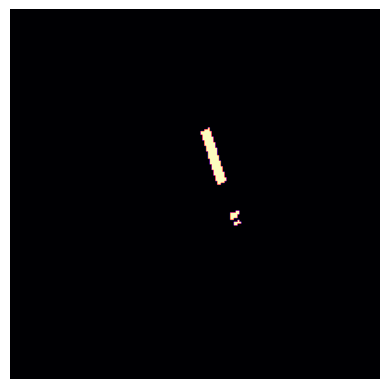

In [226]:
plt.imshow(oods[0], cmap="magma")
plt.axis("off")

tensor(718287.8750, device='cuda:7')
tensor(298.4334, device='cuda:7', grad_fn=<SumBackward0>)


(-0.5, 199.5, 199.5, -0.5)

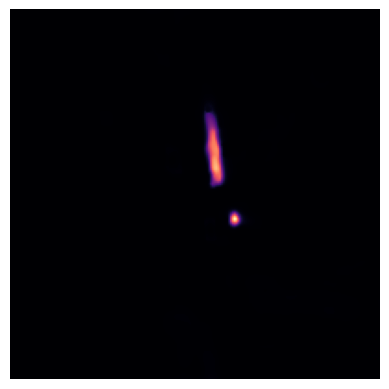

In [227]:
plt.imshow(get_ep(idx, ufce_reg_vac)[0][0, 0].detach().cpu(), cmap="magma")
plt.axis("off")

tensor(718287.8750, device='cuda:7')
tensor(490.4094, device='cuda:7', grad_fn=<SumBackward0>)


(-0.5, 199.5, 199.5, -0.5)

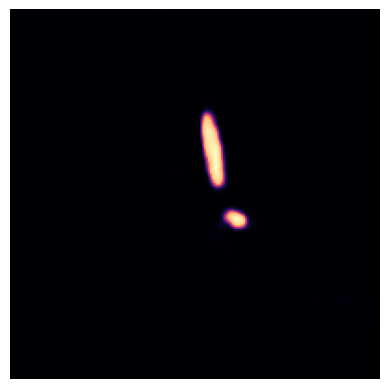

In [228]:
plt.imshow(get_ep(idx, ufce_reg)[0][0, 0].detach().cpu(), cmap="magma")
plt.axis("off")

tensor(718287.8750, device='cuda:7')
tensor(1097.7341, device='cuda:7', grad_fn=<SumBackward0>)


(-0.5, 199.5, 199.5, -0.5)

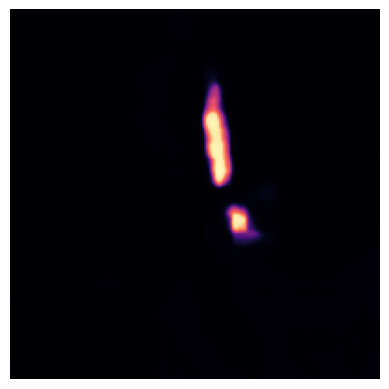

In [229]:
plt.imshow(get_ep(idx, uce_reg)[0][0, 0].detach().cpu(), cmap="magma")
plt.axis("off")

tensor(718287.8750, device='cuda:7')
tensor(144.9890, device='cuda:7', grad_fn=<SumBackward0>)


(-0.5, 199.5, 199.5, -0.5)

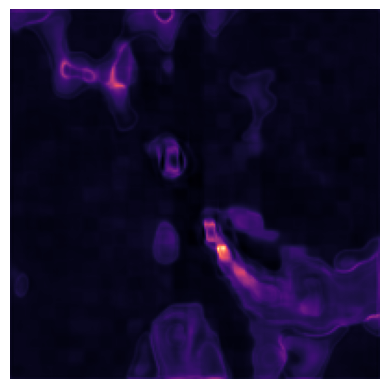

In [230]:
plt.imshow(get_ep(idx, ufce)[0][0, 0].detach().cpu(), cmap="magma")
plt.axis("off")